E*ste Script en Python, utiliza el analisis de datos para visualizar las ventas de acciones en la bolsa de Nueva York, ademas realiza predicciones basado en estos datos para el futuro*. 🤚
Utiliza los paquetes : **yfinance** -> para obtener el precio de las acciones,  **pandas** -> para poder crear el data set con el precio de las acciones y poder modelar los datos a partir de estas,
**numpy** -> para poder analizar los datos de las acciones ,
**matplotlib.pyplot** -> para poder modelar los datos de las acciones,
**SKlearn.preprocessing** -> para elegir el modelo(pre-procesado) de aprendizaje automatico para que realice las predicciones de los precios -> el modulo de este paquete que se utilizo fue MinMaxScaler,
**Keras** -> utiliza el modelo a entrenar con los datos del set de datos y los datos pre-procesados

In [ ]:
# Importar las bibliotecas necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [ ]:
# se toman los valores comezando el 2023-01-13 hasta el 2023-12-13
# Descargar los datos de precios de las acciones de Amazon
data = yf.download('AMZN', start='2023-01-13', interval='1h', end='2023-12-13', progress=False)[['Close']]
data.head()

,Close
Datetime,
2023-01-13 09:30:00-05:00,96.614998
2023-01-13 10:30:00-05:00,95.980003
2023-01-13 11:30:00-05:00,96.940102
2023-01-13 12:30:00-05:00,97.769997
2023-01-13 13:30:00-05:00,98.224998


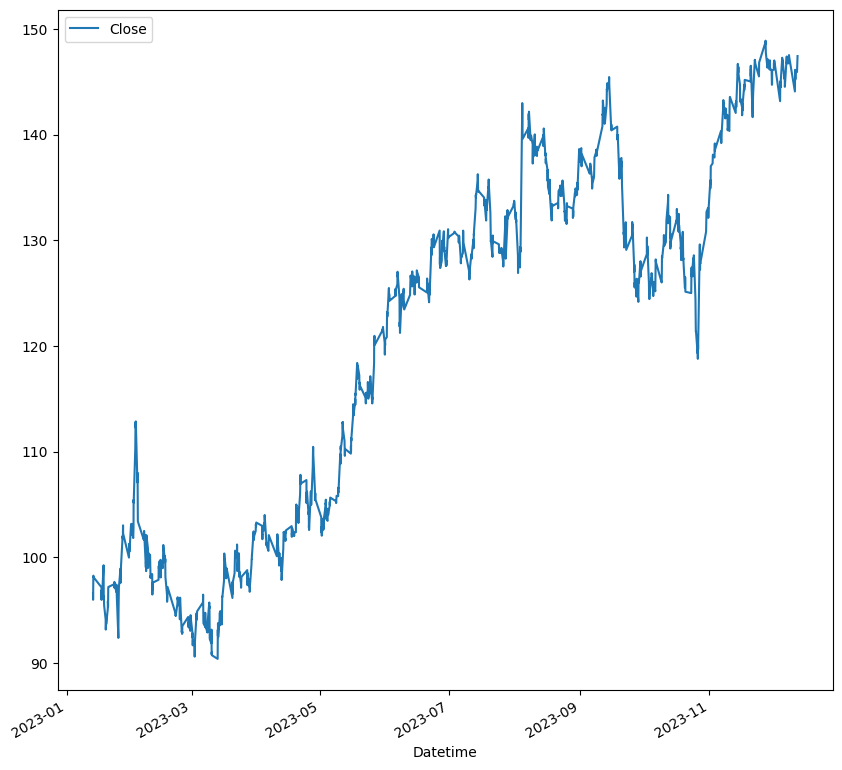

In [ ]:

# Visualizar los datos
data.plot(figsize=(10,10))

# Escalar los datos entre 0 y 1
cl = data.Close.astype('float32')
train = cl[0:int(len(cl)*0.90)]
scl = MinMaxScaler()
scl.fit(train.values.reshape(-1,1))
cl = scl.transform(cl.values.reshape(-1,1))

In [ ]:
# Crear una función para procesar los datos en segmentos de 10 observaciones
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb), 0])
        Y.append(data[(i+lb), 0])
    return np.array(X), np.array(Y)

lb = 10
X, y = processData(cl, lb)

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba (90-10)
X_train, X_test = X[:int(X.shape[0]*0.90)], X[int(X.shape[0]*0.90):]
y_train, y_test = y[:int(y.shape[0]*0.90)], y[int(y.shape[0]*0.90):]
print(X_train.shape, X_train.shape)
print(X_test.shape, X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1431, 10) (1431, 10)
(160, 10) (160, 10)
(1431,)
(160,)


In [ ]:
# Construir el modelo LSTM con una capa oculta de 256 neuronas y una capa de salida de una neurona
model = Sequential()
model.add(LSTM(256, input_shape=(lb, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Reajustar los datos para que tengan la forma (Muestra, Paso, Característica)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:

# Entrenar el modelo con los datos de entrenamiento y validar con los datos de prueba
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), shuffle=False)
model.summary()

Epoch 1/300
45/45 [==============================] - 9s 23ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 2/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 3/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 7.9756e-04
Epoch 4/300
45/45 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 9.9635e-04
Epoch 5/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 6/300
45/45 [==============================] - 0s 8ms/step - loss: 8.9955e-04 - val_loss: 0.0018
Epoch 7/300
45/45 [==============================] - 0s 10ms/step - loss: 8.4251e-04 - val_loss: 0.0016
Epoch 8/300
45/45 [==============================] - 0s 5ms/step - loss: 9.7083e-04 - val_loss: 0.0018
Epoch 9/300
45/45 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0011 - val_

45/45 [==============================] - 6s 88ms/step


Text(0.5, 1.0, 'Train Dataset')

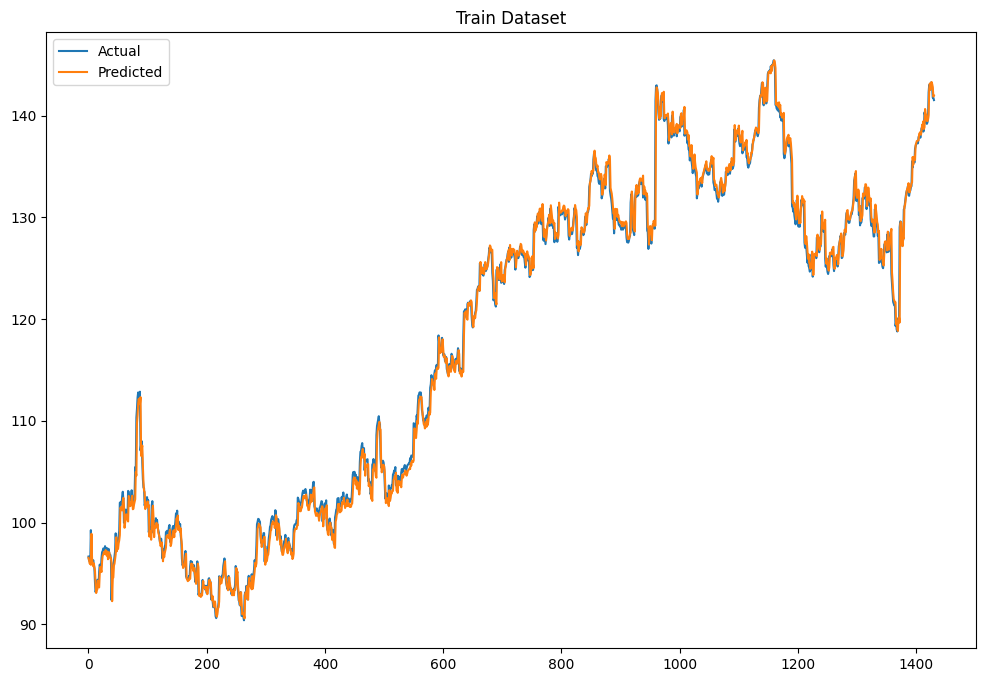

In [ ]:
# Obtener las predicciones en los conjuntos de entrenamiento y prueba
plt.figure(figsize=(12,8))
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

5/5 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'Test Dataset')

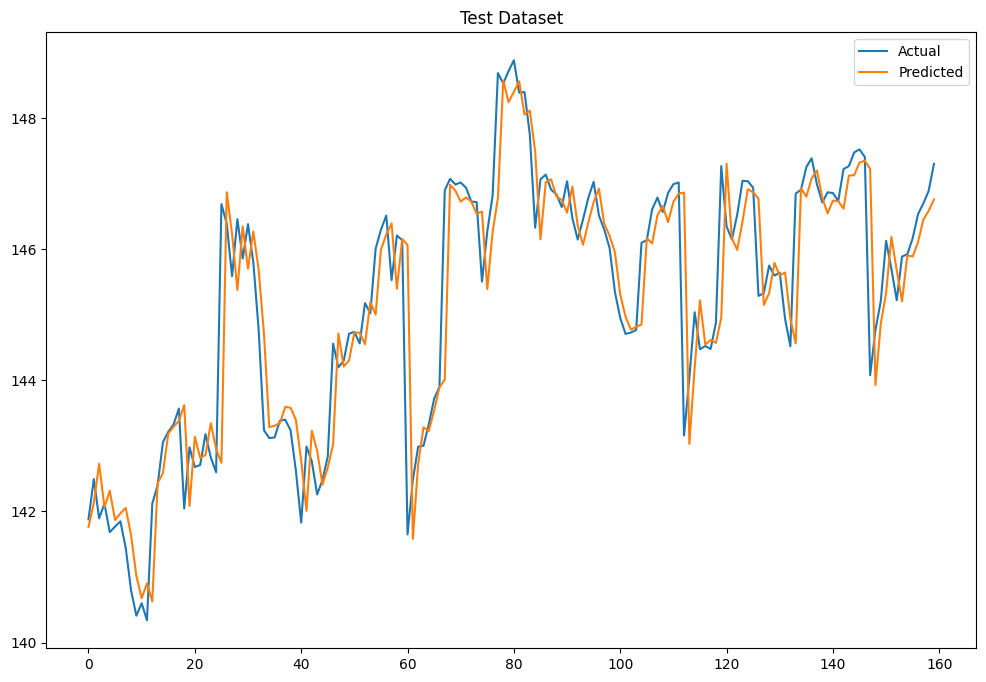

In [ ]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:

# Crear una función para procesar los datos en segmentos de 10 observaciones sin etiquetas
def processData(data, lb):
    X = []
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb), 0])
    return np.array(X)

In [ ]:
# Crear un conjunto de datos ficticio con los valores predichos como características
cl2 = cl.copy()
pred = []
for i in range(X_test.shape[0]):
    cl2[int(X.shape[0]*0.90)+i+lb] = model.predict(X_test)[i]
    pred.extend(model.predict(X_test)[i])
X = processData(cl2, lb)
X_train, X_test = X[:int(X.shape[0]*0.90)], X[int(X.shape[0]*0.90):]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

5/5 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Test Dataset 251 Obs Ahead')

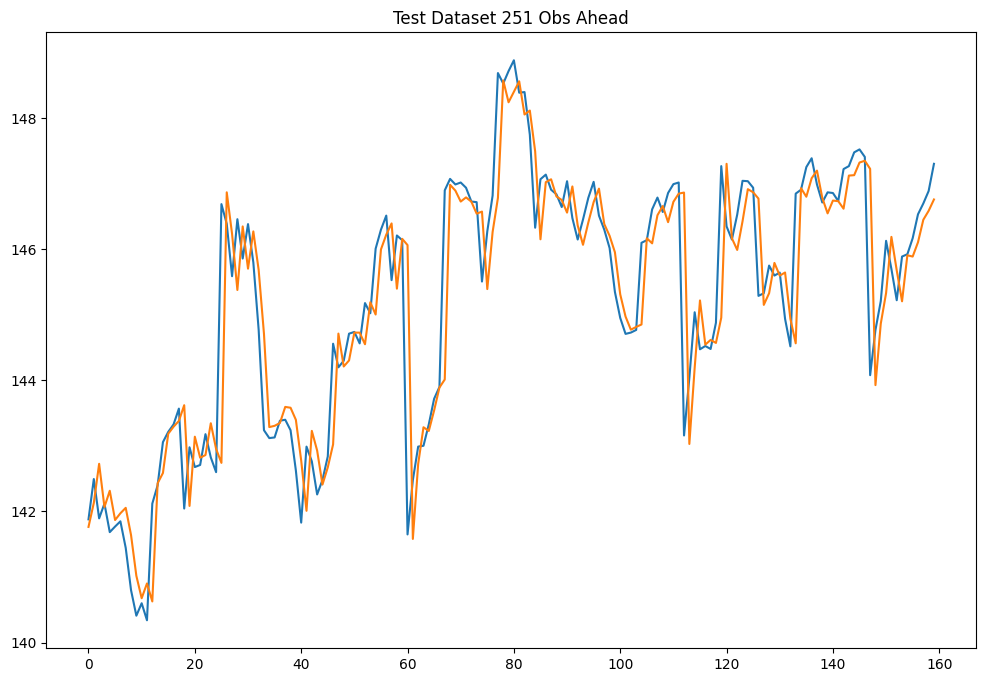

In [ ]:
# Obtener las predicciones para 251 observaciones adelante
prediction = scl.inverse_transform(np.array(pred).reshape(-1, 1))
plt.figure(figsize=(12,8))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(prediction, label="Predicted")
plt.title("Test Dataset 251 Obs Ahead")